In [1]:
from PIL import Image
import deeplocalizer as dl
import torch
from transformers import AutoImageProcessor, ResNetForImageClassification
import numpy as np
np.random.seed(0)  # for reproducibility since I use df.sample() from numpy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/Users/donnybertucci/pypi/deeplocalizer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# LOAD MODEL 
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")
model = model.to(DEVICE)

# AND DEFINE HOW TO USE IT
@torch.no_grad()
def resnet_forward(image_paths):
	images = [
		Image.open(f"./data/{p}").convert("RGB") for p in image_paths
	]
	inputs = processor(images, return_tensors="pt").to(DEVICE)
	outputs = model(**inputs)
	return outputs.logits

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
# LOAD FACE LOCALIZER TASK 
task, valid = dl.load_task("./data/task_face_localizer.parquet")
task.head()

,data,positive,validation
1000,celeba/2913.jpg,True,False
1001,celeba/3275.jpg,True,False
1002,celeba/775.jpg,True,False
1003,celeba/217.jpg,True,False
1004,celeba/1245.jpg,True,False


In [ ]:
# DEFINE WHICH ACTIVATIONS TO USE, THEN COMPUTE
resnet_blocks = [layer for stage in model.resnet.encoder.stages for layer in stage.layers] # 16 layers
activations = dl.compute_task_activations(
	df=task,
	model_forward=resnet_forward,
	layers_activations=resnet_blocks,
	batch_size=32,
)

  3%|▎         | 2/63 [00:03<01:36,  1.59s/it]

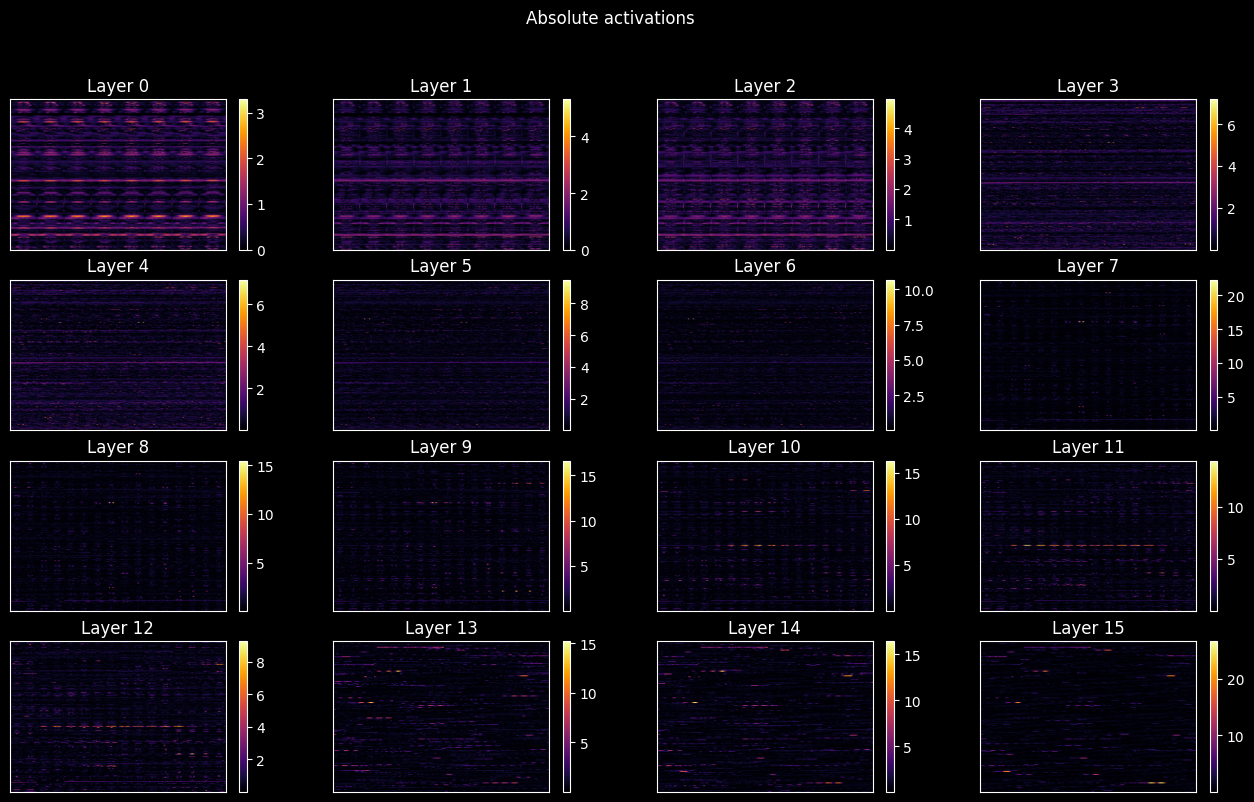

In [5]:
dl.visualize_activations(dl.overall_activation(activations), (4, 4), cmap="inferno")

In [7]:
# COMPUTE TOP PERCENT ACTIVATIONS
top_percent = 0.5
top_idxs, top_values = dl.top_percent_global(activations, top_percent)

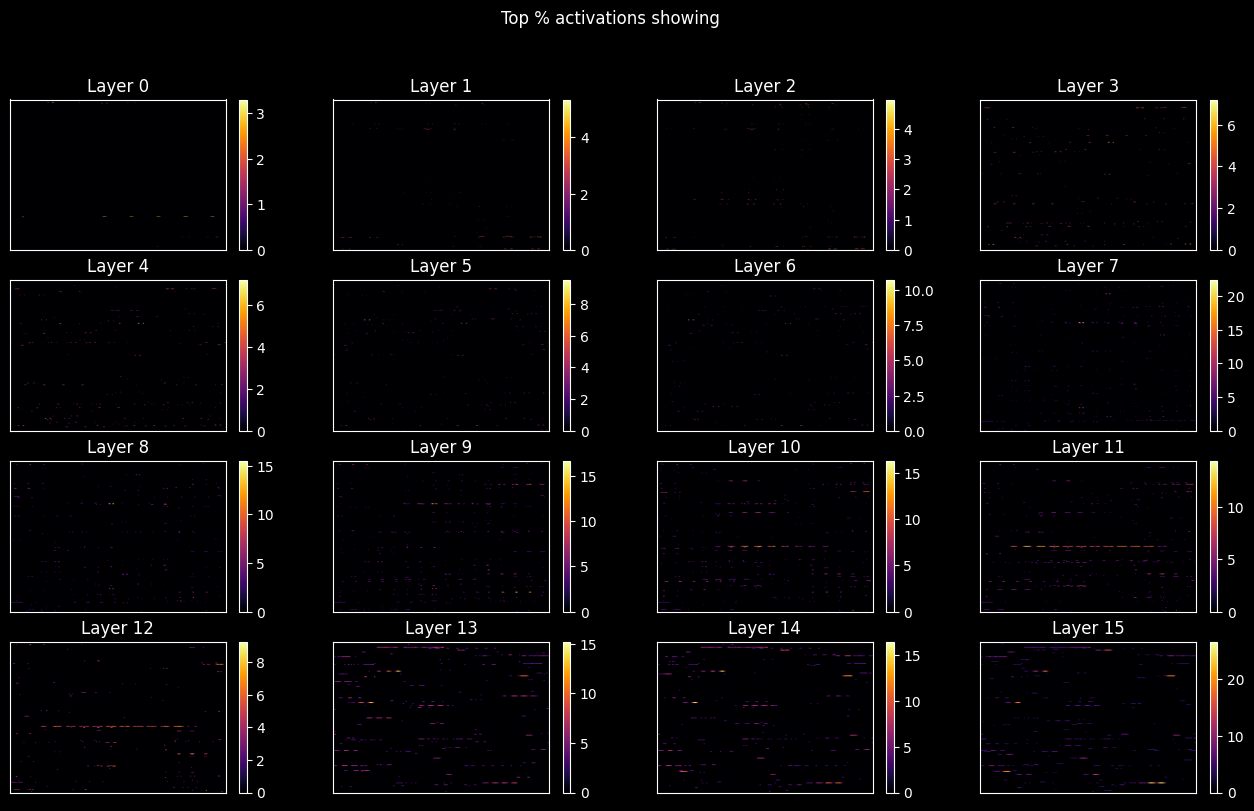

In [8]:
dl.visualize_top_activations(top_idxs, top_values, activations)

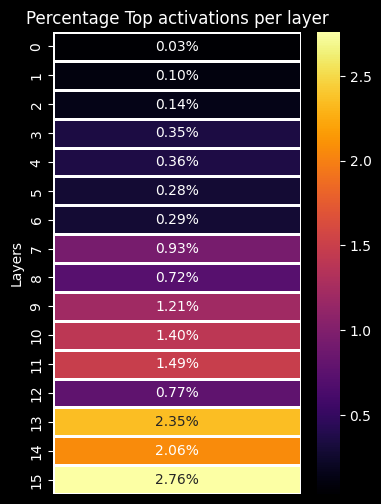

In [9]:
dl.visualize_top_per_layer(top_idxs, activations)

## Analysis

In [59]:
# See the performance on the validation set, not what we observed to see if it works!
(ablated_task, regular_task), (ablated_control, regular_control) = dl.task_ablated(
	valid, resnet_forward, resnet_blocks, top_idxs
)

100%|██████████| 32/32 [00:57<00:00,  1.81s/it]


In [62]:
regular_task_preds = regular_task.argmax(-1)
ablated_task_preds = ablated_task.argmax(-1)
shared_prediction = (regular_task_preds == ablated_task_preds).sum() / len(
	regular_task_preds
)
print(
	f"How did the predictions for the face images change after ablation? Answer: {((1 - shared_prediction) * 100).item()}%"
)

regular_control_preds = regular_control.argmax(-1)
ablated_control_preds = ablated_control.argmax(-1)
shared_prediction = (regular_control_preds == ablated_control_preds).sum() / len(
	regular_control_preds
)
print(
	f"How many changed for the control? Answer: {((1 - shared_prediction) * 100).item()}%"
)

How did the predictions for the face images change after ablation? Answer: 97.69999694824219%
How many changed for the control? Answer: 26.59999656677246%


In [63]:
def kl_divergence(p, q):
    return (p * (p/q).log()).sum(-1, keepdims=True)

task_kl =  kl_divergence(ablated_task.softmax(-1), regular_task.softmax(-1)).mean().item()
control_kl =  kl_divergence(ablated_control.softmax(-1), regular_control.softmax(-1)).mean().item()

print("How do the prob distributions differ?")
print(f"Mean task KL Divergence between ablated and not: {task_kl:.6f}")
print(f"Mean control KL Divergence between ablated and not: {control_kl:.6f}")

How do the prob distributions differ?
Mean task KL Divergence between ablated and not: 3.185665
Mean control KL Divergence between ablated and not: 0.179047
